### Load the Reddit TLDR dataset
#### Find documents with highest toxicity classification


In [2]:
# For reloading the functions from .py files so that we do not need to restart the kernel everytime
%load_ext autoreload
%autoreload 2 

from data.dataset_loader import DataSetLoader
from datasets import load_from_disk
import pandas as pd
import numpy as np
import torch

from visualization.toxicity_plot import plot_toxicity_distribution, plot_toxicity_comparison_with_length

from summarizers.factory import SummarizerFactory
from evaluation.toxicity import ToxicityScorer


### Only run the next cell if you want to subsample the dataset again, otherwise move to next code cell.

In [8]:
%load_ext autoreload
%autoreload 2 

loader = DataSetLoader()
dataset = loader.load(debug_mode=True, batch_size=128,num_entries= 20000)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading reddit_tldr dataset...


Loading dataset shards:   0%|          | 0/38 [00:00<?, ?it/s]

Debug mode: Using subset of data
Processing dataset...


Processing reddit_tldr dataset:   0%|          | 0/20000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20000 [00:00<?, ? examples/s]

### Dataset sampled for 20000 entries
 - detoxify model ran for all those entries for baseline summaries and documents.
 - We identify the top 1000 entries with highest document toxicity and visualise it

In [4]:

file ='data/reddit_tldr_20250603185109_debug_True.parquet'
dataset = load_from_disk(file)
df_dataset = dataset.to_pandas()


display(df_dataset.document_toxicity_detoxify.max())
display(df_dataset.document_toxicity_detoxify.min())
display(df_dataset.document_toxicity_detoxify.mean())


0.998914361000061

0.0004976990167051554

0.10141013004896231

### For the documents, find the top 1000 documents with higest toxicity using Detoxify model

- Alternatively try to subsample the dataset, then run sentiment classification and then create set of 1000 entries, maybe 50-50 for both.

In [5]:
df_dataset.sort_values(by='document_toxicity_detoxify', ascending=False, inplace=True)
top_1000 = df_dataset[df_dataset['document_length'] > 300]
top_1000 = top_1000.head(1000).copy()
top_1000.sort_values(by='document_length', ascending=True, inplace=True)

### Distribution of toxicity of documents and summaries

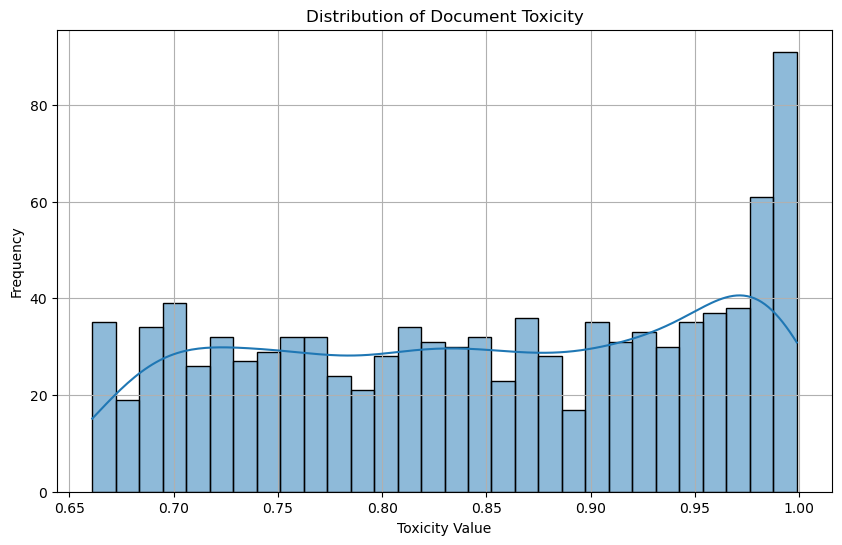

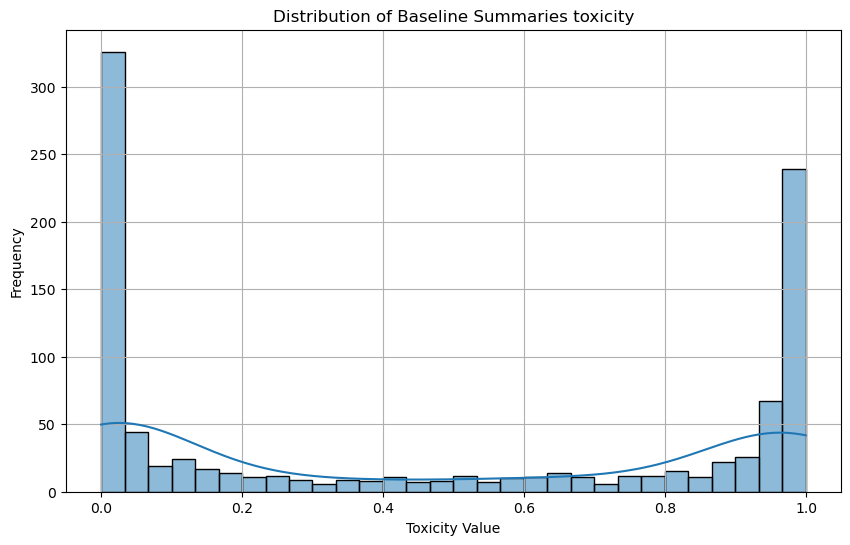

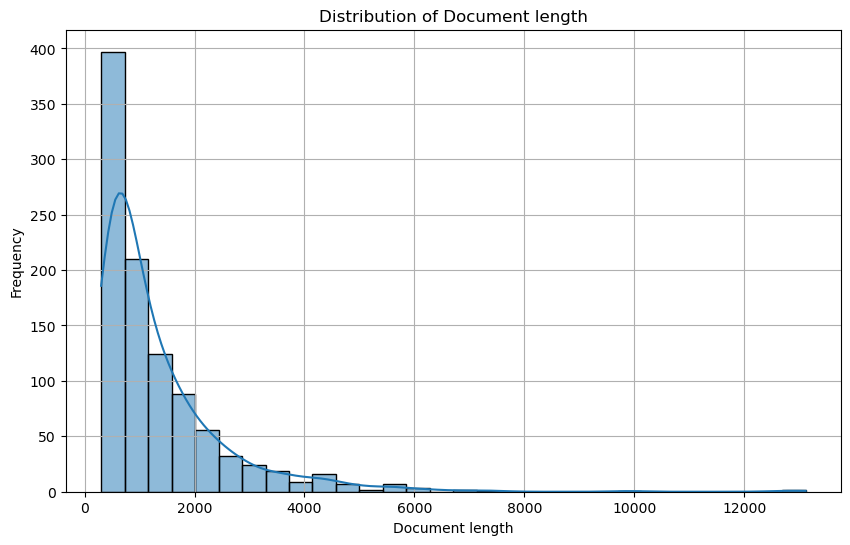

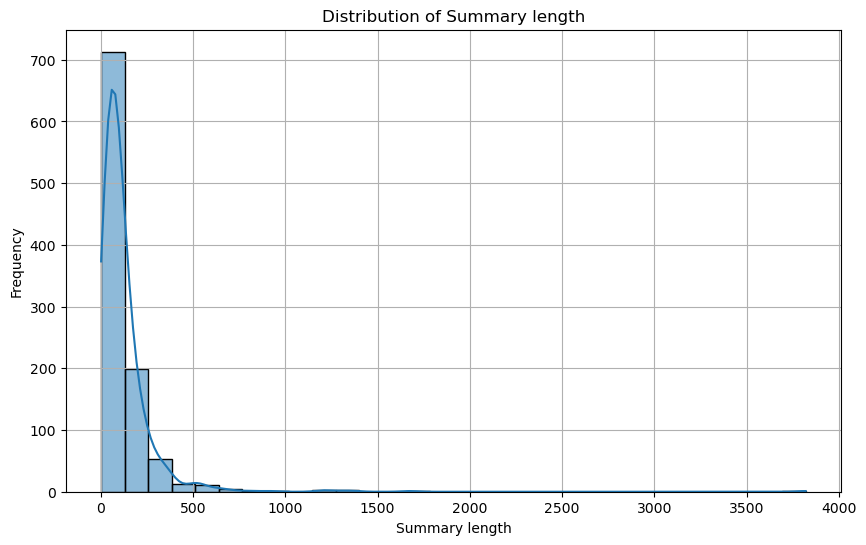

In [4]:
%reload_ext autoreload



# plot document toxicity distribution
plot_toxicity_distribution(top_1000['document_toxicity_detoxify'])


# plot baseline summaries toxicity distribution
plot_toxicity_distribution(top_1000['summary_toxicity_detoxify'], label='Distribution of Baseline Summaries toxicity')

# plot document length distribution
plot_toxicity_distribution(top_1000['document_length'], label='Distribution of Document length', x_label='Document length')


# plot summary length distribution
plot_toxicity_distribution(top_1000['summary_length_baseline'], label='Distribution of Summary length', x_label='Summary length')



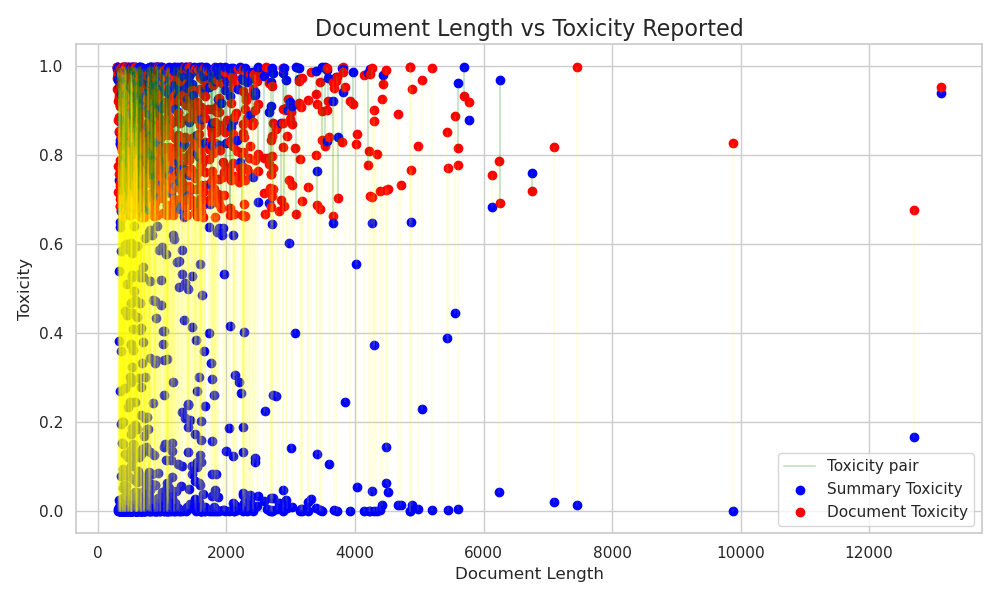

In [5]:
%matplotlib ipympl



plot_toxicity_comparison_with_length(top_1000['summary_toxicity_detoxify'], top_1000['document_toxicity_detoxify'], top_1000['document_length'])



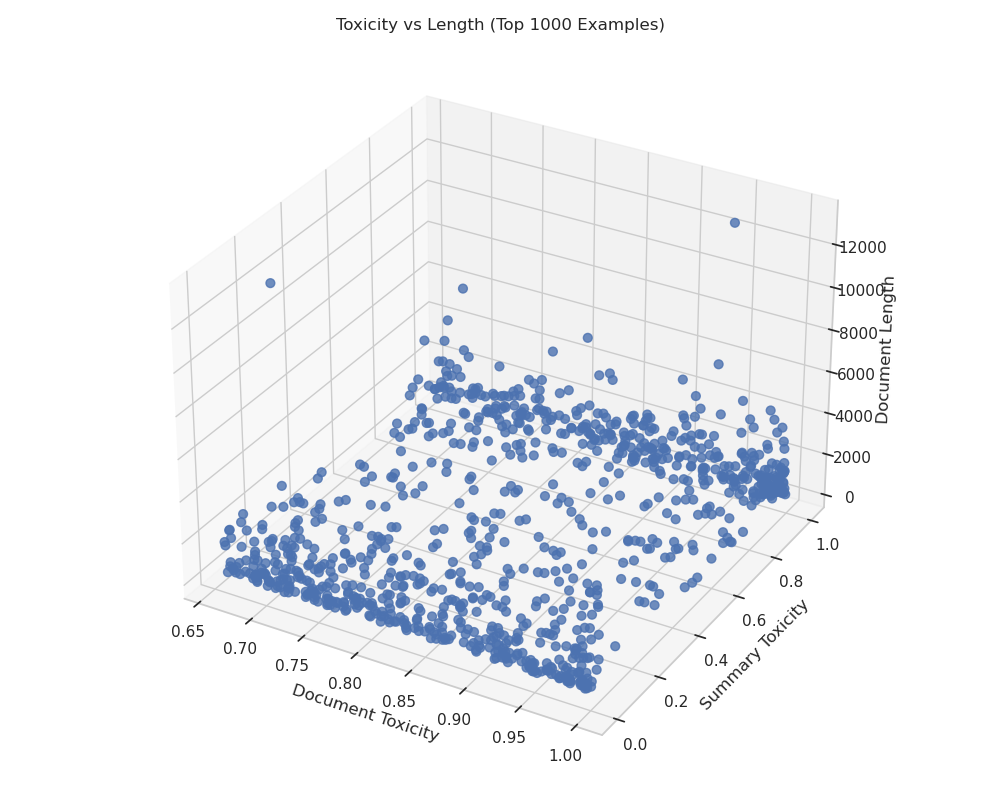

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_toxicity_comparison_with_length(summary_toxicity, document_toxicity, document_length):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111,projection='3d')
    
    # 3D scatter plot
    sc = ax.scatter(document_toxicity, summary_toxicity, document_length,
                     s=40, alpha=0.8)
    
    # Axis labels
    ax.set_xlabel('Document Toxicity')
    ax.set_ylabel('Summary Toxicity')
    ax.set_zlabel('Document Length')
    ax.set_title('Toxicity vs Length (Top 1000 Examples)')

    # Colorbar represents summary toxicity
    # cbar = plt.colorbar(sc, pad=0.1)
    # cbar.set_label('Summary Toxicity')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


plot_toxicity_comparison_with_length(top_1000['summary_toxicity_detoxify'], top_1000['document_toxicity_detoxify'], top_1000['document_length'])


remove outliers - document length is high
check if document length, (not token length) is less than 

In [6]:
df_dataset.sort_values(by='document_toxicity_detoxify', ascending=False, inplace=True)
top_1000_filtered = df_dataset[(df_dataset['document_length'] > 300) & (df_dataset['document_length'] <= 6000)]
top_1000_filtered = top_1000_filtered.head(1000).copy()
top_1000_filtered.sort_values(by='document_length', ascending=True, inplace=True)

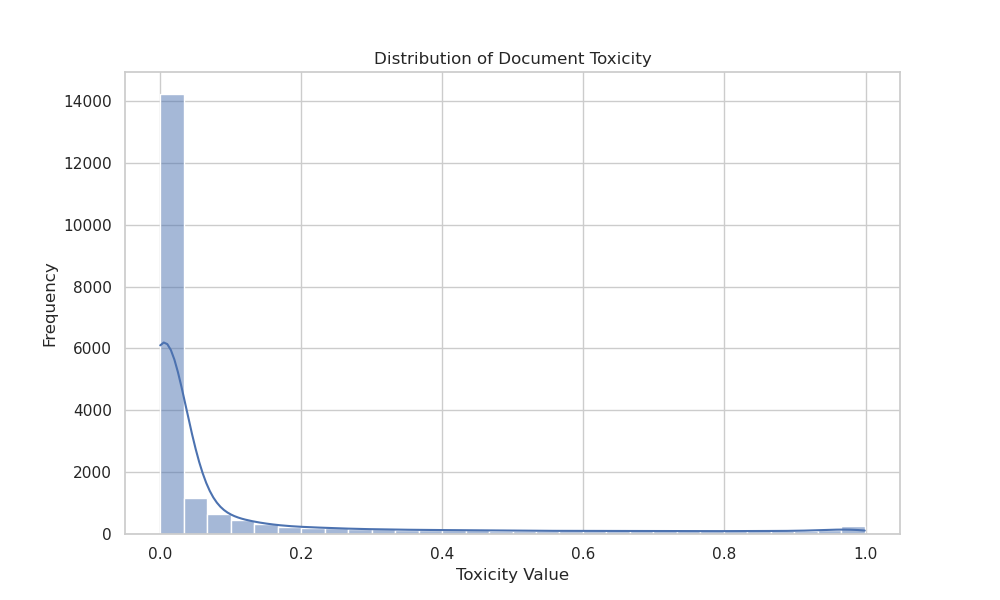

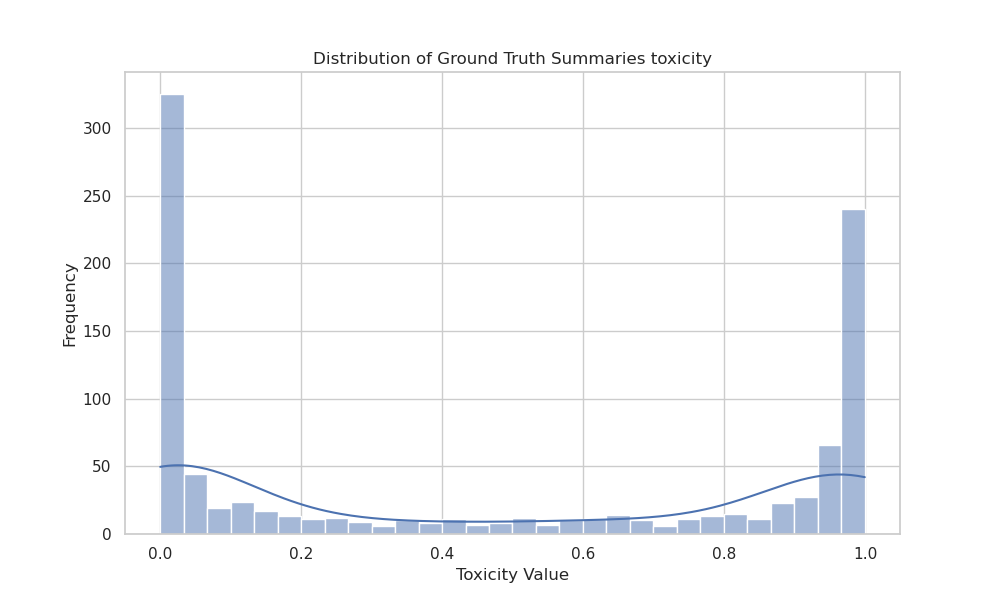

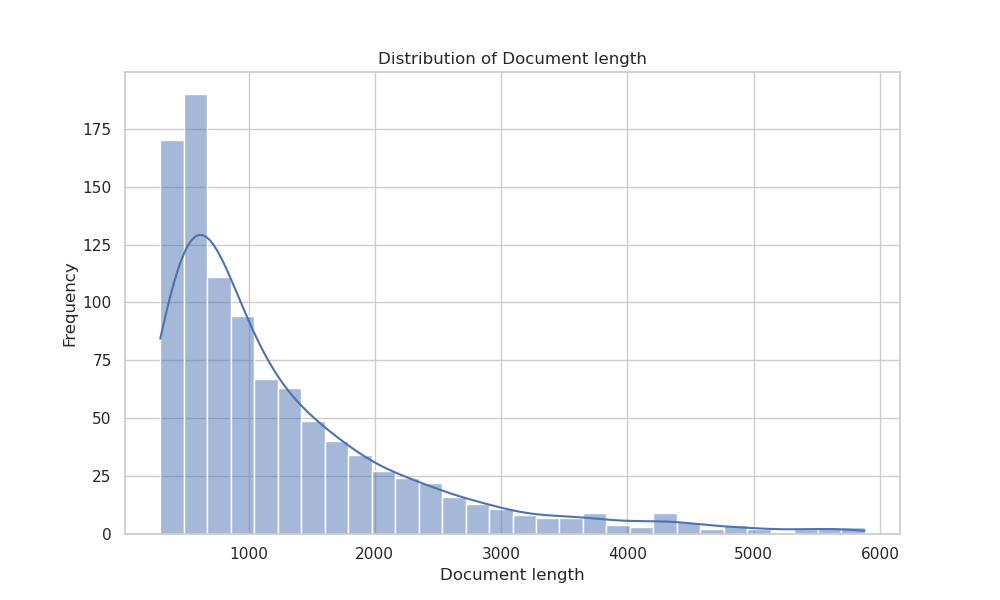

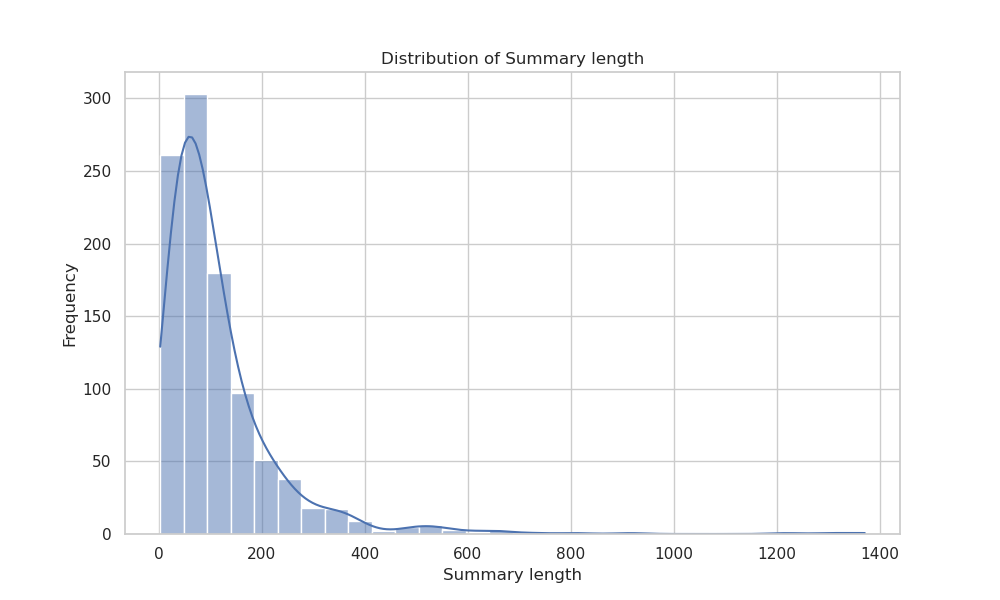

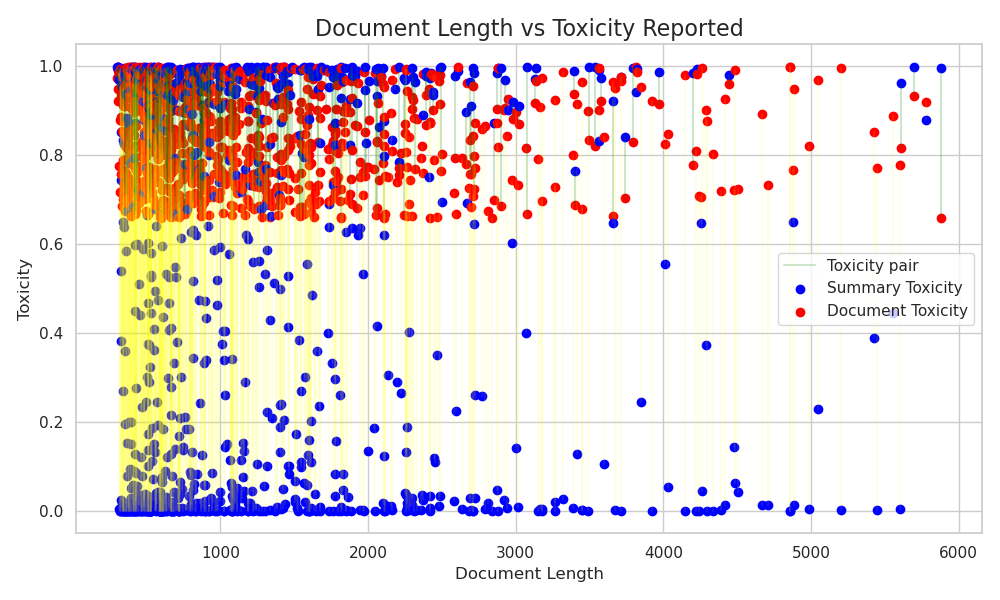

In [31]:
%reload_ext autoreload



# plot document toxicity distribution
plot_toxicity_distribution(df_dataset['document_toxicity_detoxify'])


# plot baseline summaries toxicity distribution
plot_toxicity_distribution(top_1000_filtered['summary_toxicity_detoxify'], label='Distribution of Ground Truth Summaries toxicity')

# plot document length distribution
plot_toxicity_distribution(top_1000_filtered['document_length'], label='Distribution of Document length', x_label='Document length')


# plot summary length distribution
plot_toxicity_distribution(top_1000_filtered['summary_length_baseline'], label='Distribution of Summary length', x_label='Summary length')

%matplotlib ipympl



plot_toxicity_comparison_with_length(top_1000_filtered['summary_toxicity_detoxify'], top_1000_filtered['document_toxicity_detoxify'], top_1000_filtered['document_length'])




## Summarisation using BART and T5

In [8]:


summarizer_factory = SummarizerFactory()
summarizers = ['bart','t5']

for summarizer in summarizers:
    summaries = summarizer_factory.summarize(summarizer, top_1000_filtered['document'].values)
    top_1000_filtered[summarizer+'_summary'] = summaries
    top_1000_filtered[summarizer+'_summary_length'] = [len(summary) for summary in summaries]


# Save to CSV as a checkpoint
top_1000_filtered.to_csv("data/model_summaries_bart_t5_lt.csv", index=False)
    





Device set to use cuda:0
Device set to use cuda:0


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 200, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Yo

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)
Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)
Your max_length is set to 200, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 200, but your input_length is only 95. Since this is a summarization task, where out

In [9]:
results = pd.read_csv('data/model_summaries_bart_t5_lt.csv')

# display(results['bart_summary_length'])
# display(results['summary_length_baseline'])
# display(results['document_length'][712])
# display(results['t5_summary_length'])

In [10]:
results.keys()

Index(['document', 'document_length', 'summary_baseline',
       'summary_length_baseline', 'document_toxicity_detoxify',
       'summary_toxicity_detoxify', 'document_severe_toxicity_detoxify',
       'summary_severe_toxicity_detoxify', 'document_obscene_detoxify',
       'summary_obscene_detoxify', 'document_threat_detoxify',
       'summary_threat_detoxify', 'document_insult_detoxify',
       'summary_insult_detoxify', 'document_identity_attack_detoxify',
       'summary_identity_attack_detoxify', 'bart_summary',
       'bart_summary_length', 't5_summary', 't5_summary_length'],
      dtype='object')

In [11]:

from tqdm import tqdm


class DataFrameEnricher:
    def __init__(self, df):
        self.df = df
        self.tox_api = ToxicityScorer()

    def add_toxicity_scores(self, columns_to_score, batch_size=16):  # Adjust batch size as needed
        for column in columns_to_score:
            # Calculate perspective scores
            perspective_scores = self.tox_api.score_perspective(self.df[column].values.tolist())
            self.df[f'{column}_perspective_toxicity'] = perspective_scores
            
            # Clear memory after perspective scores
            del perspective_scores
            torch.cuda.empty_cache()  # Clear GPU memory if using GPU

            # Calculate detoxify scores in batches
            detoxify_results = []
            for i in range(0, len(self.df[column]), batch_size):
                batch_texts = self.df[column].values.tolist()[i:i + batch_size]
                batch_results = self.tox_api.score_detoxify(batch_texts)
                detoxify_results.append(batch_results)

            # Flatten the list of results and assign to DataFrame
            detoxify_results = {key: [result for batch in detoxify_results for result in batch[key]] for key in detoxify_results[0].keys()}
            for key in detoxify_results.keys():
                self.df[f'{column}_{key}_detoxify'] = detoxify_results[key]

            # Clear memory after detoxify scores
            del detoxify_results
            torch.cuda.empty_cache()  # Clear GPU memory if using GPU

        return self.df


enricher = DataFrameEnricher(results.copy())
enriched_df = enricher.add_toxicity_scores(['bart_summary', 't5_summary'])

enriched_df.to_csv('data/final_results_1000.csv',index=False)

100%|██████████| 1000/1000 [16:42<00:00,  1.00s/it] 


In [4]:
final = pd.read_csv('data/final_results_1000.csv')

In [7]:
display(final.bart_summary_perspective_toxicity.max())
display(final.t5_summary_perspective_toxicity.max())
final.keys()

0.9817629

0.95048624

Index(['document', 'document_length', 'summary_baseline',
       'summary_length_baseline', 'document_toxicity_detoxify',
       'summary_toxicity_detoxify', 'document_severe_toxicity_detoxify',
       'summary_severe_toxicity_detoxify', 'document_obscene_detoxify',
       'summary_obscene_detoxify', 'document_threat_detoxify',
       'summary_threat_detoxify', 'document_insult_detoxify',
       'summary_insult_detoxify', 'document_identity_attack_detoxify',
       'summary_identity_attack_detoxify', 'bart_summary',
       'bart_summary_length', 't5_summary', 't5_summary_length',
       'bart_summary_perspective_toxicity', 'bart_summary_toxicity_detoxify',
       'bart_summary_severe_toxicity_detoxify',
       'bart_summary_obscene_detoxify', 'bart_summary_threat_detoxify',
       'bart_summary_insult_detoxify', 'bart_summary_identity_attack_detoxify',
       't5_summary_perspective_toxicity', 't5_summary_toxicity_detoxify',
       't5_summary_severe_toxicity_detoxify', 't5_summary_obs

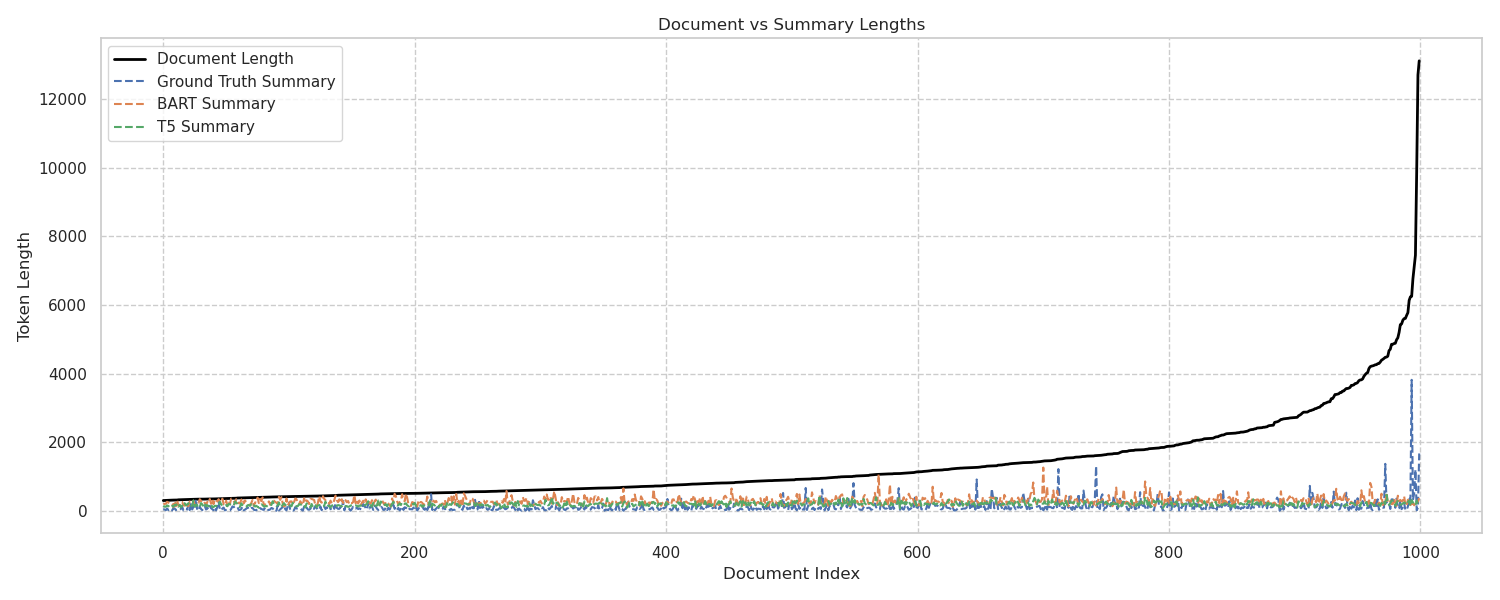

In [16]:
##Plot Document vs Summary Length
from visualization.toxicity_plot import plot_document_vs_summary_lengths

df = pd.read_csv("data/model_summaries_bart_t5_lt.csv")
plot_document_vs_summary_lengths(df)


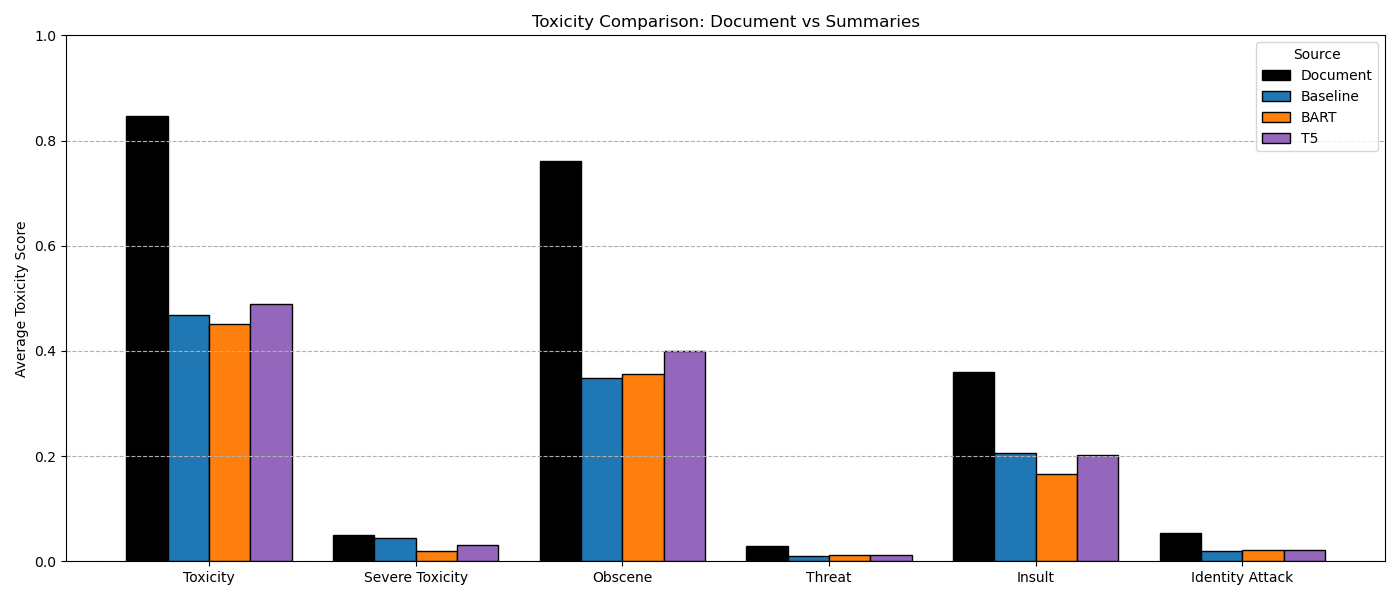

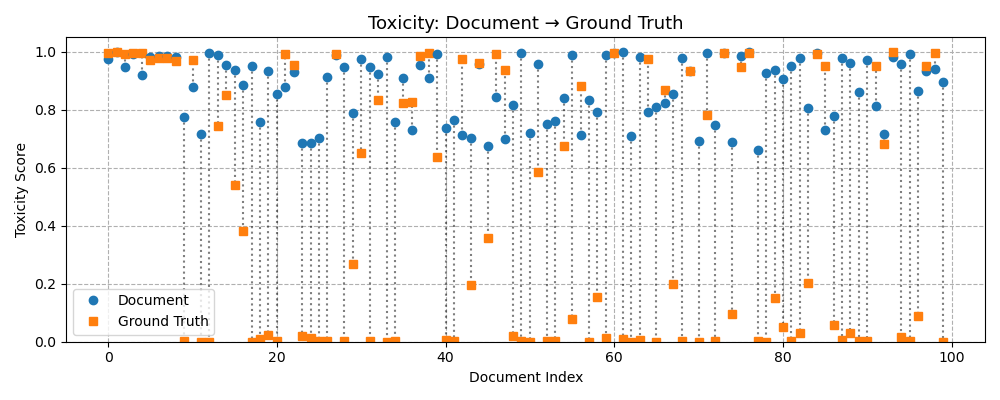

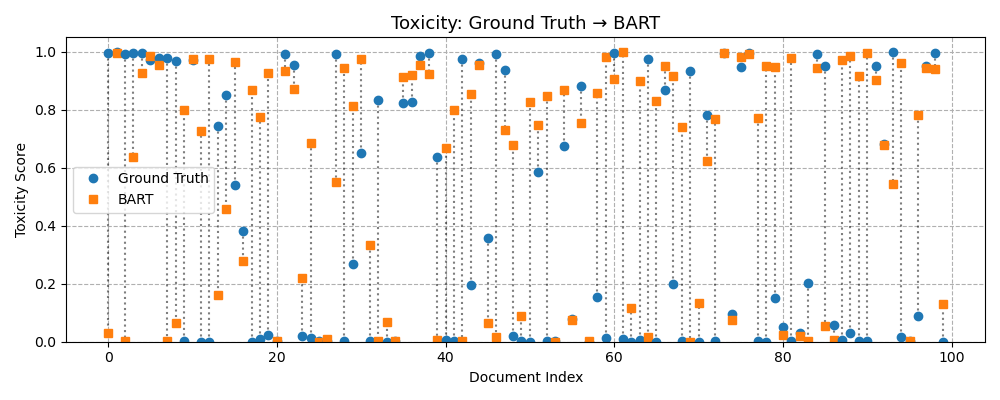

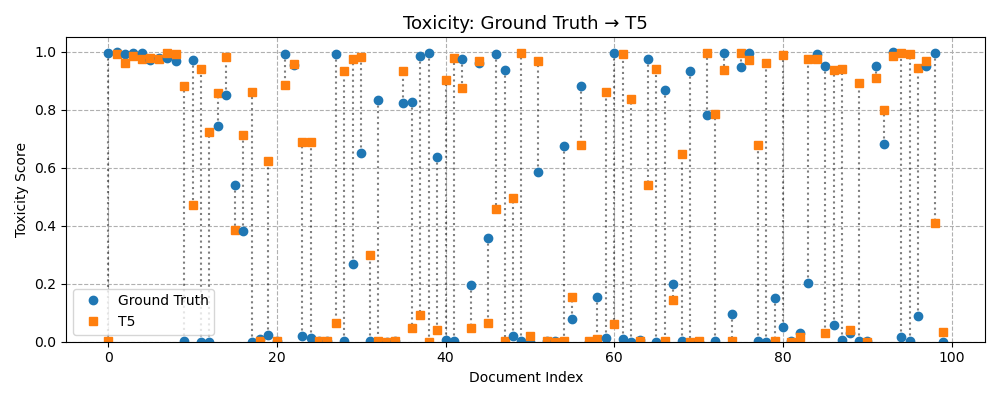

/home/arunima/NLP/text-summarisation-eval/Text-Summarisation-Eval/project/visualization/toxicity_plot.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 4))


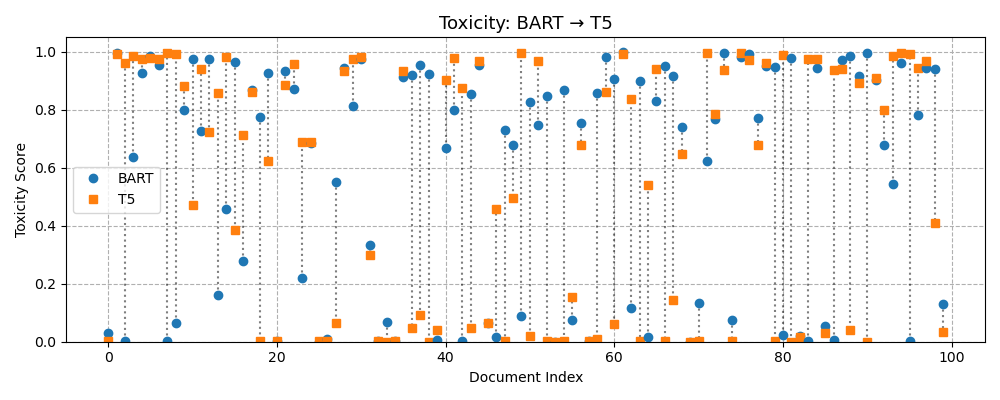

In [21]:
##Plot Toxicity Comparision

from visualization.toxicity_plot import plot_avg_toxicity_comparison, plot_toxicity_transitions

df = pd.read_csv("data/final_results_1000.csv")
plot_avg_toxicity_comparison(df)
plot_toxicity_transitions(df, top_n=100)


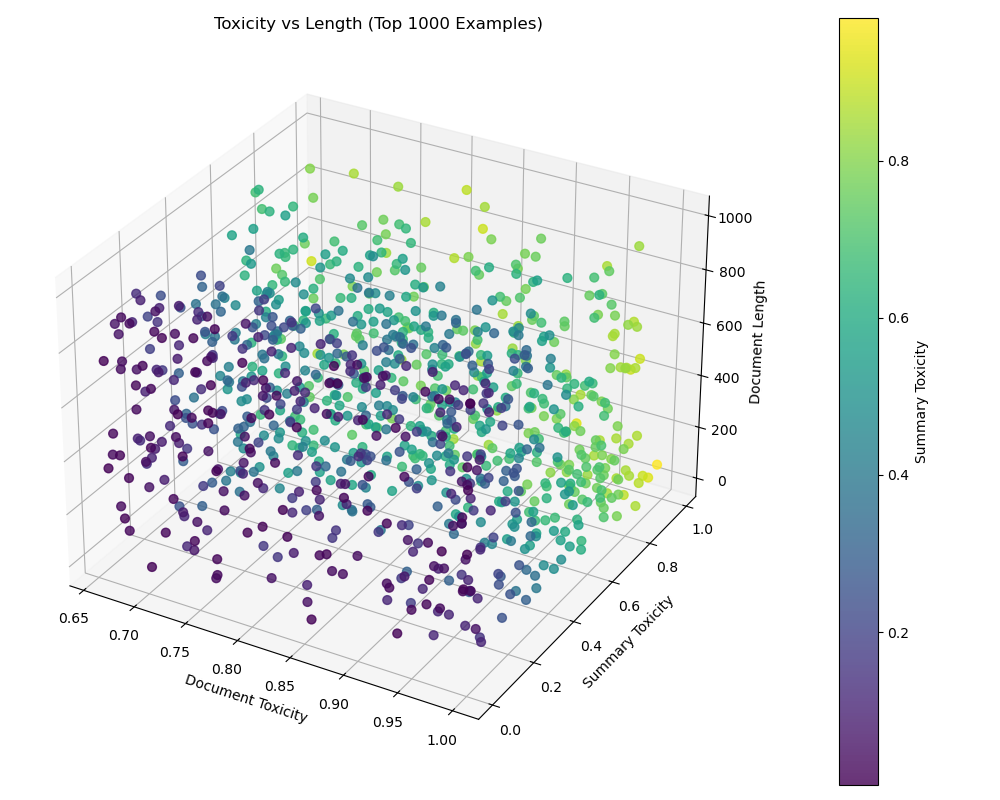

In [27]:
def plot_toxicity_comparison_with_length_3d(summary_toxicity, document_toxicity, document_length):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111,projection='3d')
    
    # 3D scatter plot
    sc = ax.scatter(document_toxicity, summary_toxicity, document_length, c=summary_toxicity,
                     s=40, alpha=0.8)
    
    # Axis labels
    ax.set_xlabel('Document Toxicity')
    ax.set_ylabel('Summary Toxicity')
    ax.set_zlabel('Document Length')
    ax.set_title('Toxicity vs Length (Top 1000 Examples)')

    # Colorbar represents summary toxicity
    cbar = plt.colorbar(sc, pad=0.1)
    cbar.set_label('Summary Toxicity')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_toxicity_comparison_with_length_3d(df['bart_summary_perspective_toxicity'], df['document_toxicity_detoxify'], df.index)

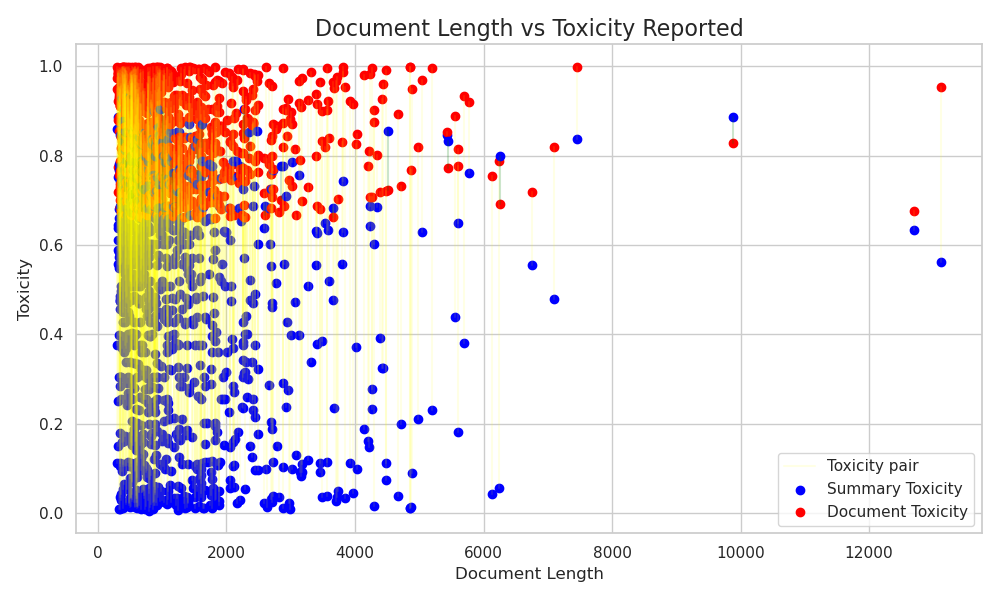

In [30]:
from visualization.toxicity_plot import plot_toxicity_comparison_with_length

plot_toxicity_comparison_with_length(df['bart_summary_perspective_toxicity'], df['document_toxicity_detoxify'], df['document_length'])

In [61]:
##Rouge Metric Evaluation
from evaluation.rouge import evaluate_rouge_scores
df = pd.read_csv("data/model_summaries_bart_t5.csv")
df = evaluate_rouge_scores(df)
df.to_csv("data/model_summaries_with_rouge.csv", index=False)

Evaluating ROUGE: 100%|████████████| 1000/1000 [00:11<00:00, 90.21it/s]


Average ROUGE F1 Scores:

summary_baseline:
  ROUGE1: 0.1074
  ROUGE2: 0.0259
  ROUGEL: 0.0724

bart_summary:
  ROUGE1: 0.4653
  ROUGE2: 0.4435
  ROUGEL: 0.4536

t5_summary:
  ROUGE1: 0.3273
  ROUGE2: 0.2777
  ROUGEL: 0.2984


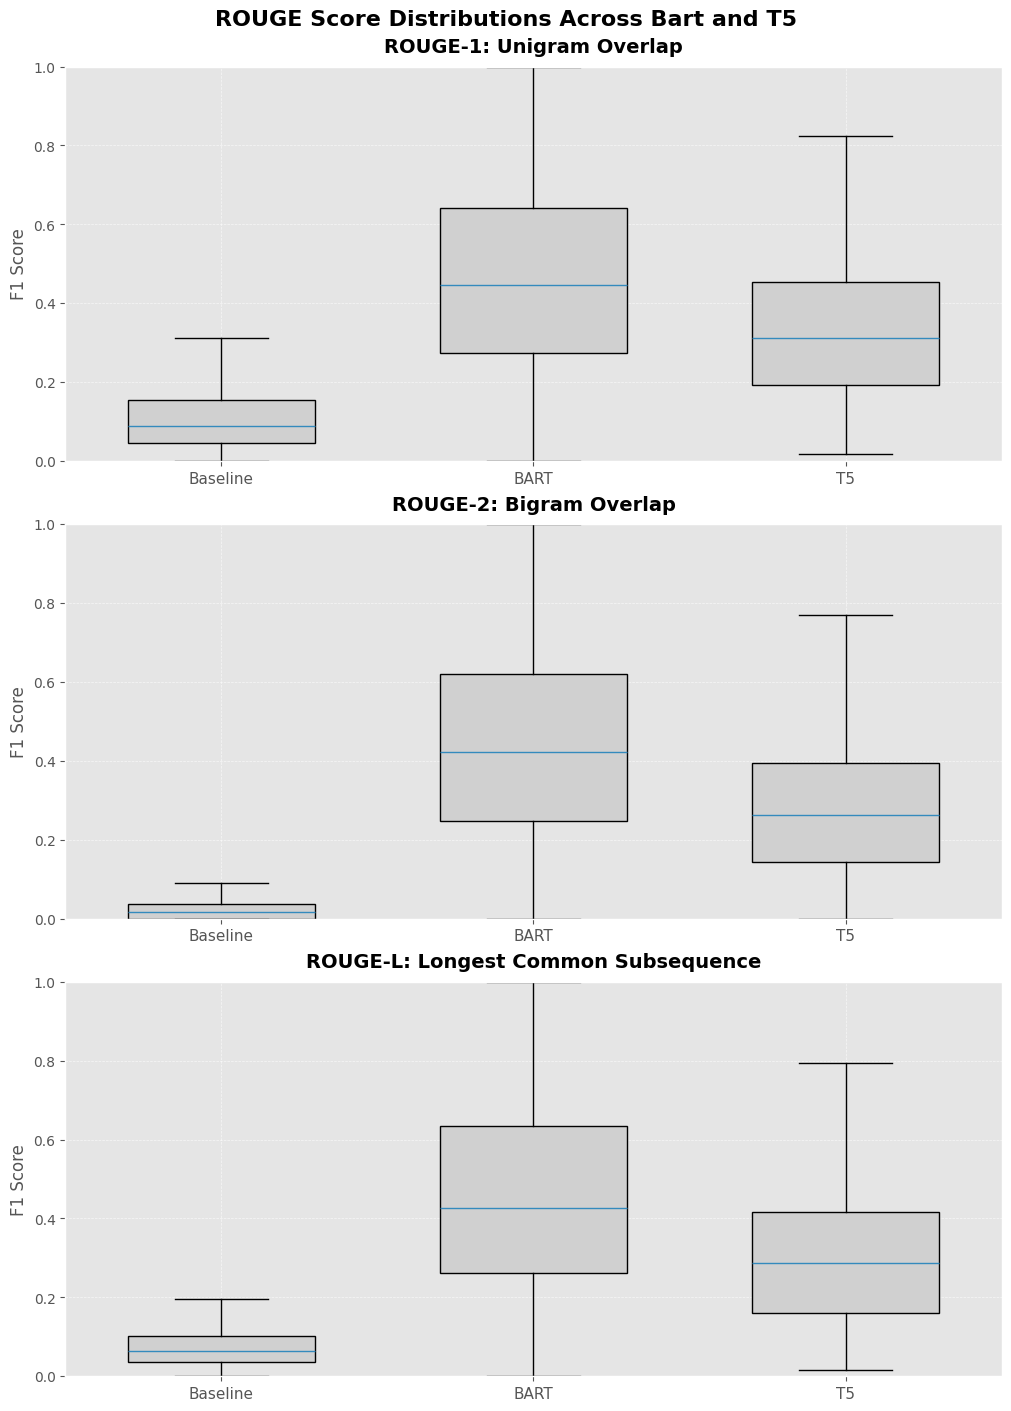

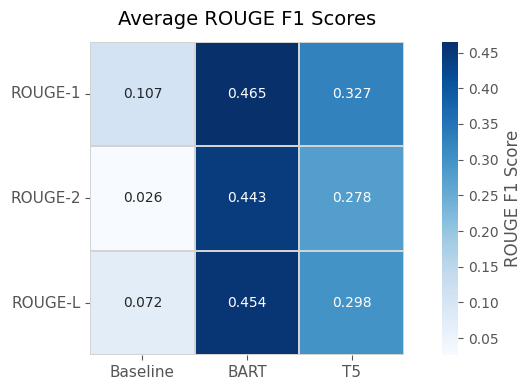

In [62]:
## Plot Rouge Score Distribution
from visualization.rouge_plots import plot_rouge_distributions, plot_rouge_average_heatmap

plot_rouge_distributions()
df_scores = plot_rouge_average_heatmap()


In [3]:
from visualization.toxicity_plot import plot_cohens_kappa

df = pd.read_csv("data/final_results_1000.csv")

# plot_cohens_kappa(top_1000_filtered)

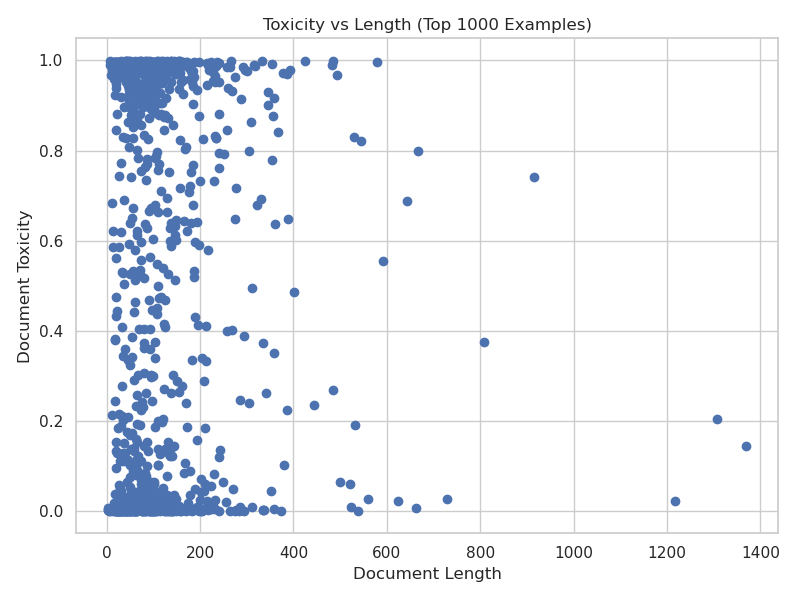

In [26]:
def plot_toxicity_comparison_with_length_3d( document_toxicity, document_length):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    
    # 3D scatter plot
    # sc = ax.scatter(document_toxicity, document_length,
    #                  s=40, alpha=0.8)
    ax.scatter( document_length, document_toxicity)
    # Axis labels
    ax.set_ylabel('Document Toxicity')
    ax.set_xlabel('Document Length')
    ax.set_title('Toxicity vs Length (Top 1000 Examples)')

    # Colorbar represents summary toxicity
    # cbar = plt.colorbar(sc, pad=0.1)
    # cbar.set_label('Document Toxicity')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_toxicity_comparison_with_length_3d( top_1000_filtered['summary_toxicity_detoxify'], top_1000_filtered['summary_length_baseline'])

In [30]:
print("Median values:")
print(f"Document toxicity: {np.median(df_dataset['document_toxicity_detoxify'].values):.3f}")
print(f"Summary toxicity: {np.median(df_dataset['summary_toxicity_detoxify'].values):.3f}")
print(f"Document length: {np.median(df_dataset['document_length'].values):.1f}")
print(f"Summary length: {np.median(df_dataset['summary_length_baseline'].values):.1f}")
print("\nMean values:")
print(f"Document toxicity: {np.mean(df_dataset['document_toxicity_detoxify'].values):.3f}")
print(f"Summary toxicity: {np.mean(df_dataset['summary_toxicity_detoxify'].values):.3f}")
print(f"Document length: {np.mean(df_dataset['document_length'].values):.1f}")

Median values:
Document toxicity: 0.004
Summary toxicity: 0.003
Document length: 1025.0
Summary length: 98.0

Mean values:
Document toxicity: 0.101
Summary toxicity: 0.160
Document length: 1477.4



Detailed Analysis of Document Length vs Toxicity:
Short documents (≤1000 tokens):
  - 9.5% are toxic (toxicity > 0.5)
  - 90.5% are non-toxic (toxicity ≤ 0.5)

Long documents (>1000 tokens):
  - 6.9% are toxic (toxicity > 0.5)
  - 93.1% are non-toxic (toxicity ≤ 0.5)

Cohen's Kappa: -0.026
Interpretation:
- No/minimal relationship between document length and toxicity


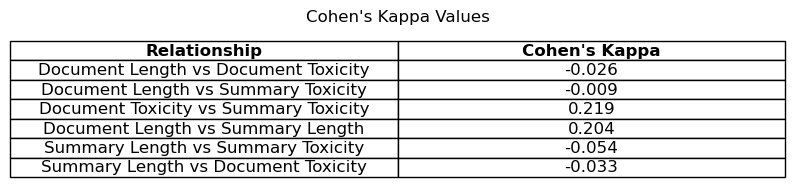

In [10]:
plot_cohens_kappa(df_dataset)

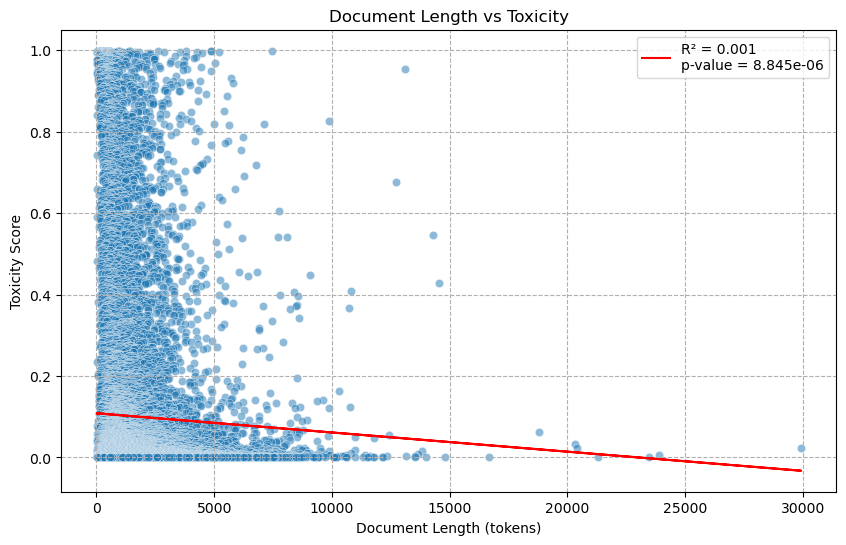


Correlation Analysis:
Correlation coefficient (r): -0.031
R-squared (R²): 0.001
p-value: 8.845e-06
Slope: -4.714e-06

Mean Toxicity Comparison:
Short documents (≤1025 tokens): 0.107
Long documents (>1025 tokens): 0.096


In [6]:
from visualization.toxicity_plot import plot_length_toxicity_correlation

plot_length_toxicity_correlation(df_dataset)